In [49]:
%pip install scipy pandas matplotlib jupyter --quiet

Note: you may need to restart the kernel to use updated packages.


In [50]:
import logging
import pathlib
import re
import numpy

import matplotlib.pyplot as plt
import pandas

log = logging.getLogger(__name__)

In [51]:
def normalize_data(
        data: pandas.DataFrame, sampling_rate: int = 5000
) -> pandas.DataFrame:
    mean: float = numpy.mean(data)
    scaling_factor: int = 3.3 / 65535
    num_samples: int = len(data)
    time_index = numpy.arange(num_samples) / sampling_rate
    data["voltage"] = (data["sample"] - mean) * scaling_factor

    new_data = data[["voltage"]]
    new_data.index = time_index

    return new_data

In [52]:
def crop_data(
        df: pandas.DataFrame,
        col: str = "voltage",
        baseline_frac: float = 0.1,
        N: float = 5,
        pre_buffer: int = 5,
) -> pandas.DataFrame:
    threshold = 1.1

    log.info(f"Noise theshold is {threshold} Volts")

    # Find first index where abs(signal) exceeds threshold
    signal_start = numpy.argmax(df[col].abs().values > threshold)
    # Add a small buffer before the detected start (if possible)

    start_idx = max(signal_start - pre_buffer, 0)

    log.info(f"Discarding {start_idx} samples at start")
    return df.iloc[start_idx:].copy()

In [53]:
def generate_plot_from_data(
        cropped_data: pandas.DataFrame,
        length: int,
        experiment_number: int,
        sampling_rate: int = 5000,
):
    # Build a time axis (in seconds) from the row index
    time_axis = numpy.arange(len(cropped_data)) / sampling_rate
    voltage = cropped_data["voltage"].to_numpy()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(time_axis, voltage, s=6, color="tab:blue", marker="o", alpha=0.9)

    # Aesthetics
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (V)")
    ax.set_title(f"Voltage vs Time {length=}, {experiment_number=}")
    ax.grid(True, which="both", linestyle="--", linewidth=0.4)

    fig.tight_layout()
    plt.show()

    filename = f"plot_{length}cm_exp{experiment_number}.png"
    fig.savefig(filename, dpi=150)


def filter_data(
        df: pandas.DataFrame, col: str = "voltage", min_period: float = 0.002
) -> pandas.DataFrame:
    voltage = df[col].values
    times = df.index.values

    # Find zero crossings (where sign changes)
    signs = numpy.sign(voltage)
    sign_changes = numpy.diff(signs)
    crossing_indices = numpy.where(sign_changes != 0)[0]

    # Interpolate to find more accurate crossing times
    crossing_times = []
    for idx in crossing_indices:
        v1, v2 = voltage[idx], voltage[idx + 1]
        t1, t2 = times[idx], times[idx + 1]
        # Linear interpolation to get approximate zero crossing time
        if v2 != v1:
            t_cross = t1 - v1 * (t2 - t1) / (v2 - v1)
        else:
            t_cross = t1
        crossing_times.append(t_cross)

    # Filter out crossings closer together than min_period
    filtered_times = []
    last_time = -numpy.inf
    for t in crossing_times:
        if t - last_time >= min_period:
            filtered_times.append(t)
            last_time = t

    # Build a DataFrame for filtered zero crossings
    filtered_df = pandas.DataFrame(
        {col: numpy.zeros(len(filtered_times))},
        index=pandas.Index(filtered_times, name="time"),
    )

    return filtered_df


def calculate_frequency(zero_crossings_data: pandas.DataFrame) -> float:
    frequency = (1 / numpy.mean(numpy.diff(zero_crossings_data.index))) / 2
    return frequency


def calculate_youngs_modulus(
        freqency: float, free_overhang_length: float, height_m=0.00076, width_m=0.0255
) -> float:
    second_moment_of_area = (width_m * height_m**3) / 12
    free_overhang_length_m: float = free_overhang_length / 100
    mass_per_unit_area = 0.051 / 0.33

    youngs_modulus: float = (
                                    3.189 * freqency**2 * mass_per_unit_area * free_overhang_length_m **4
                            ) / second_moment_of_area

    return  youngs_modulus


def process_file(
        file_object: pathlib.Path, length: int, experiment_number: int
) -> pandas.DataFrame:
    log.info(f"Processing: {file_object.name=}, {length=}, {experiment_number=}")
    raw_data: pandas.DataFrame = pandas.read_csv(
        file_object, header=None, names=["sample"]
    )
    log.info(f"Loaded {len(raw_data)} rows of data")
    normalized_data: pandas.DataFrame = normalize_data(raw_data)
    cropped_data: pandas.DataFrame = crop_data(normalized_data)

    plt = generate_plot_from_data(
        cropped_data, length=length, experiment_number=experiment_number
    )

    zero_crossings = filter_data(cropped_data)
    log.info(f"Found {len(zero_crossings)} zero crossings.")

    frequency: float = calculate_frequency(zero_crossings)

    youngs_modulus: float = calculate_youngs_modulus(frequency, length)

    log.info(f"Calculated {frequency}, {youngs_modulus=}")

    return pandas.DataFrame(data=[{
        "length":length,
        "experminent_number":experiment_number,
        "frequency":frequency,
        "youngs_modulus":youngs_modulus,
    }])






INFO:__main__:Found 14 inputs to process.
INFO:__main__:Processing iteration i=0
INFO:__main__:Processing: file_object.name='15cm1.csv', length=15, experiment_number=1
INFO:__main__:Loaded 14997 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 4721 samples at start


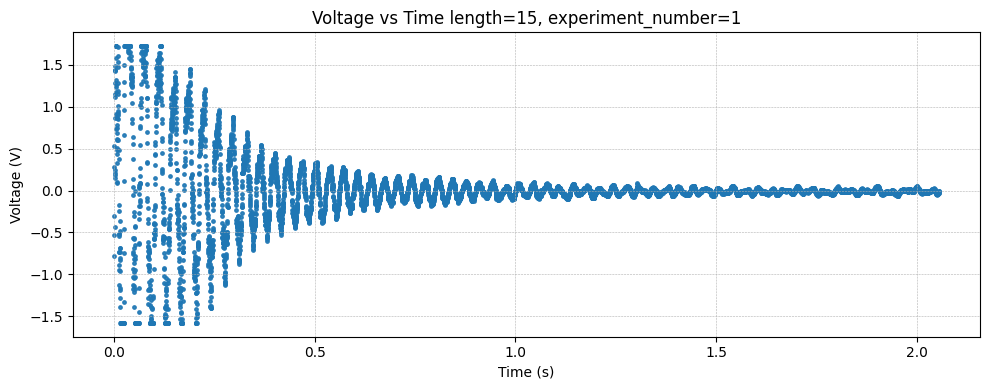

INFO:__main__:Found 170 zero crossings.
INFO:__main__:Calculated 41.32703452446531, youngs_modulus=np.float64(456819428889.97955)
INFO:__main__:Processing iteration i=1
INFO:__main__:Processing: file_object.name='15cm2.csv', length=15, experiment_number=2
INFO:__main__:Loaded 14999 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 4706 samples at start


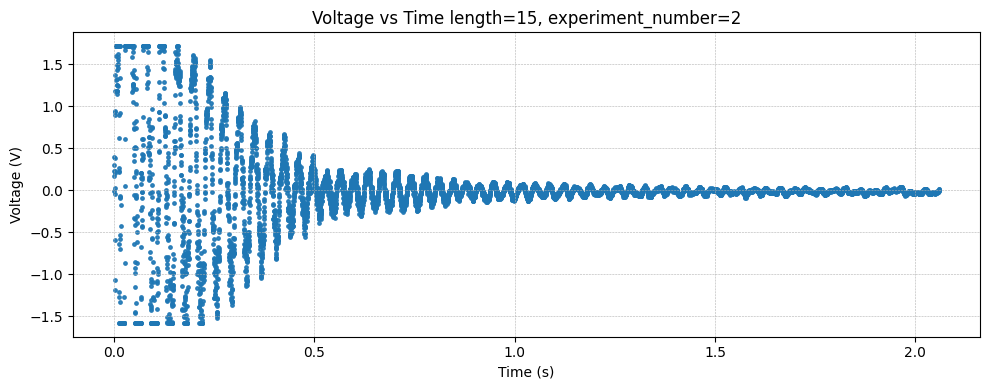

INFO:__main__:Found 188 zero crossings.
INFO:__main__:Calculated 45.435848342953165, youngs_modulus=np.float64(552170706598.3059)
INFO:__main__:Processing iteration i=2
INFO:__main__:Processing: file_object.name='15cm3.csv', length=15, experiment_number=3
INFO:__main__:Loaded 15001 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 4013 samples at start


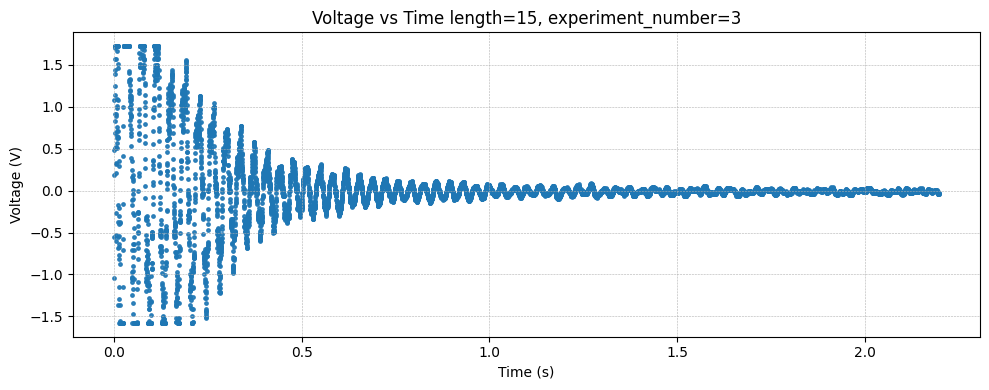

INFO:__main__:Found 185 zero crossings.
INFO:__main__:Calculated 41.982582426570964, youngs_modulus=np.float64(471426920649.41296)
INFO:__main__:Processing iteration i=3
INFO:__main__:Processing: file_object.name='13cm3.csv', length=13, experiment_number=3
INFO:__main__:Loaded 15001 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 5157 samples at start


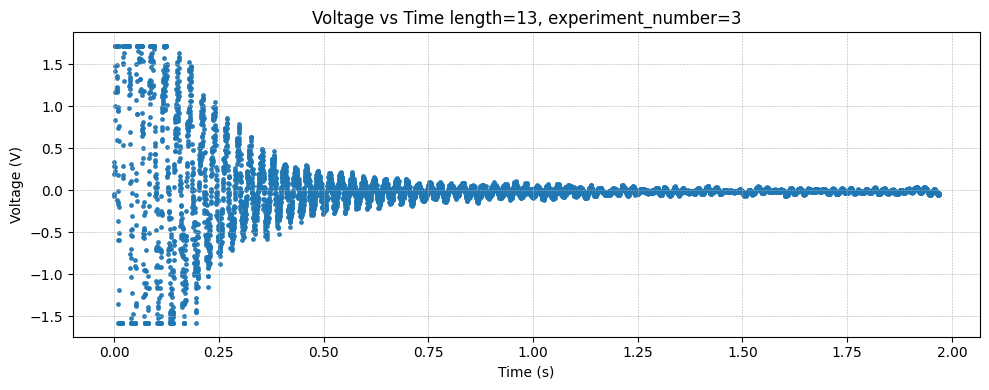

INFO:__main__:Found 287 zero crossings.
INFO:__main__:Calculated 72.97738147971207, youngs_modulus=np.float64(803639002662.2119)
INFO:__main__:Processing iteration i=4
INFO:__main__:Processing: file_object.name='13cm2.csv', length=13, experiment_number=2
INFO:__main__:Loaded 15000 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 6188 samples at start


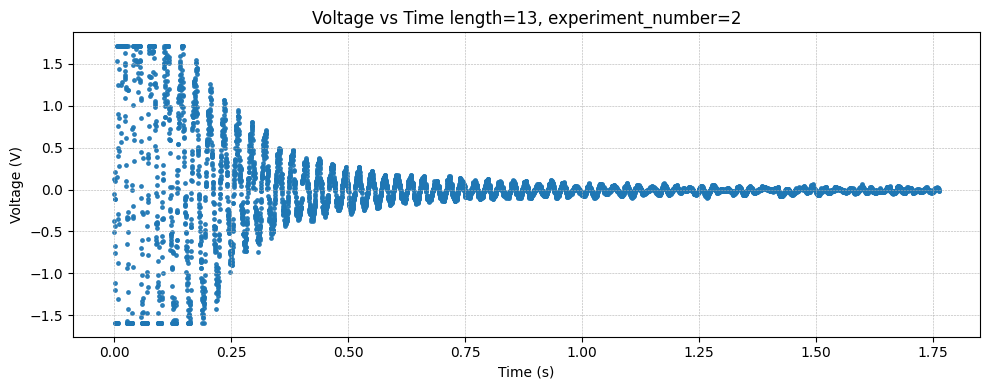

INFO:__main__:Found 190 zero crossings.
INFO:__main__:Calculated 53.648256493002854, youngs_modulus=np.float64(434305849127.5269)
INFO:__main__:Processing iteration i=5
INFO:__main__:Processing: file_object.name='25cm1.csv', length=25, experiment_number=1
INFO:__main__:Loaded 19993 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 5824 samples at start


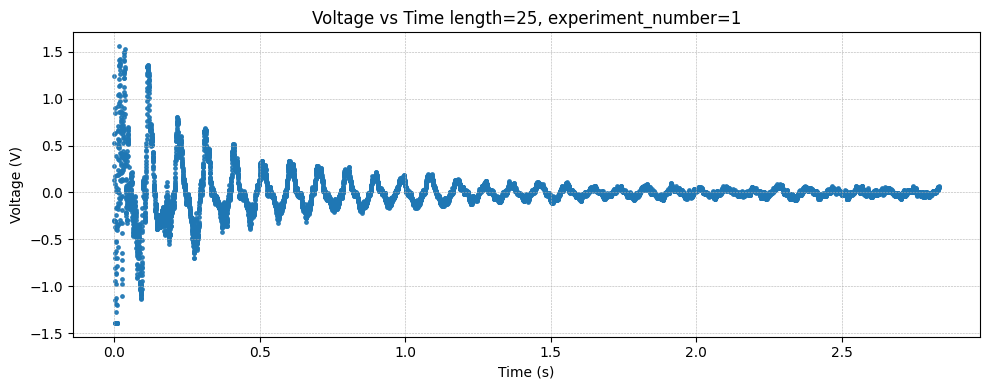

INFO:__main__:Found 200 zero crossings.
INFO:__main__:Calculated 35.27333115742655, youngs_modulus=np.float64(2567816766781.9624)
INFO:__main__:Processing iteration i=6
INFO:__main__:Processing: file_object.name='13cm1.csv', length=13, experiment_number=1
INFO:__main__:Loaded 14997 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 9511 samples at start


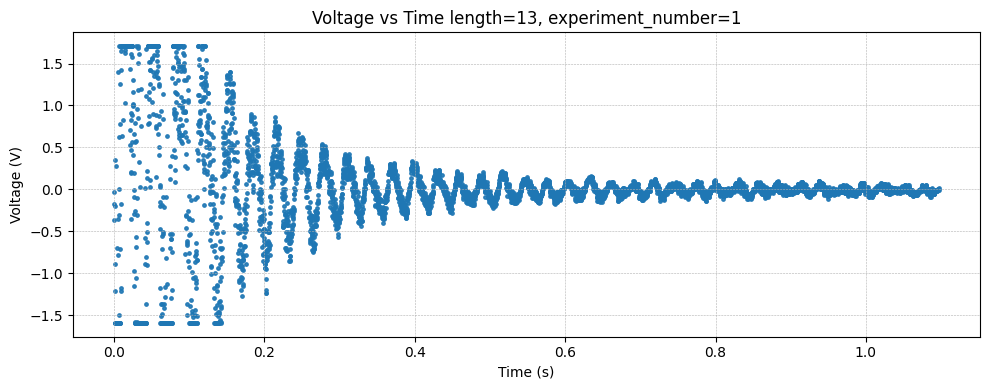

INFO:__main__:Found 179 zero crossings.
INFO:__main__:Calculated 81.3385358482469, youngs_modulus=np.float64(998336971135.3359)
INFO:__main__:Processing iteration i=7
INFO:__main__:Processing: file_object.name='14cm1.csv', length=14, experiment_number=1
INFO:__main__:Loaded 19991 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 6674 samples at start


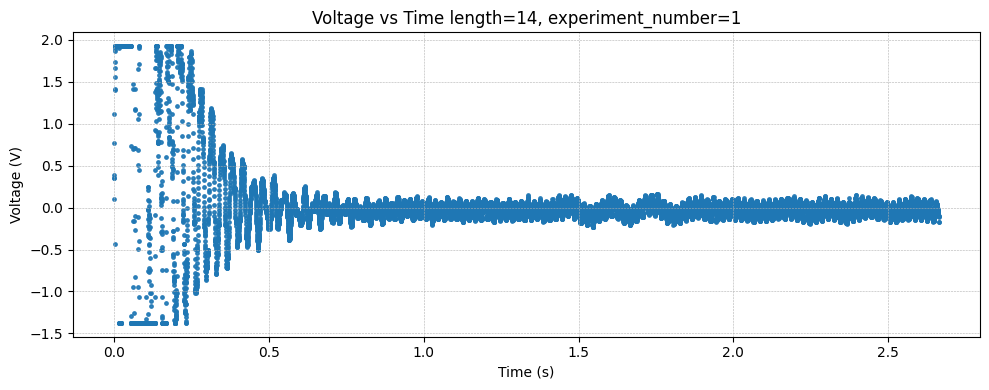

INFO:__main__:Found 247 zero crossings.
INFO:__main__:Calculated 46.29295478876202, youngs_modulus=np.float64(434963676263.7941)
INFO:__main__:Processing iteration i=8
INFO:__main__:Processing: file_object.name='18cm1.csv', length=18, experiment_number=1
INFO:__main__:Loaded 19993 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 8810 samples at start


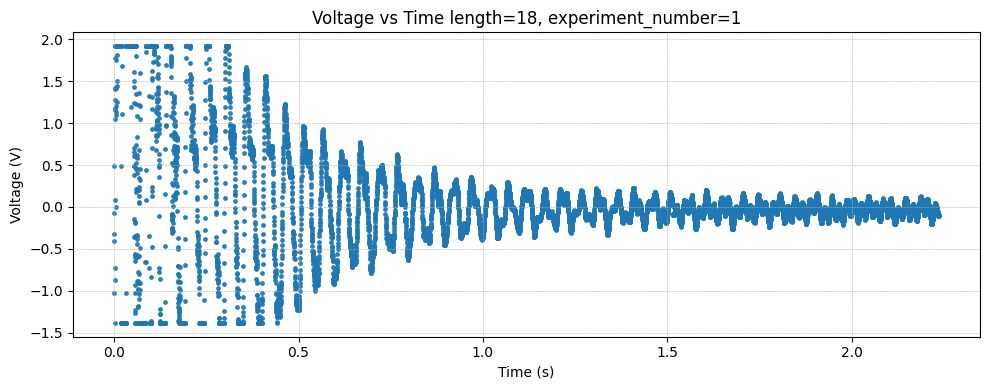

INFO:__main__:Found 143 zero crossings.
INFO:__main__:Calculated 31.866201025187078, youngs_modulus=np.float64(563198705202.1815)
INFO:__main__:Processing iteration i=9
INFO:__main__:Processing: file_object.name='20cm1.csv', length=20, experiment_number=1
INFO:__main__:Loaded 19992 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 5894 samples at start


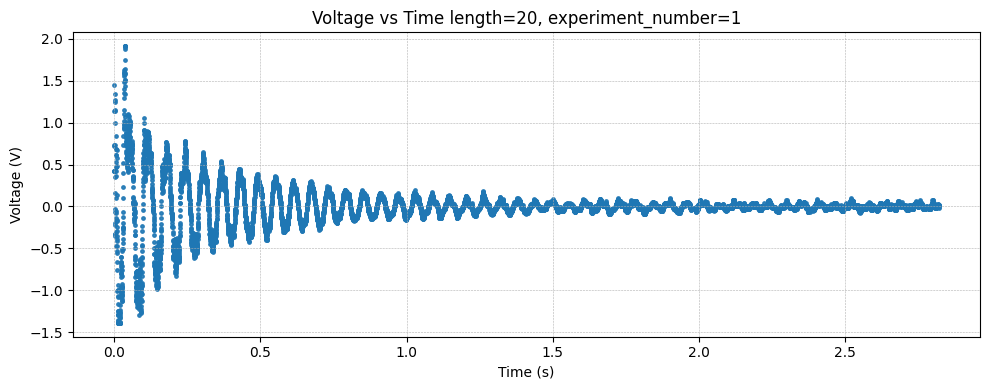

INFO:__main__:Found 180 zero crossings.
INFO:__main__:Calculated 31.781283747775348, youngs_modulus=np.float64(853834892268.4006)
INFO:__main__:Processing iteration i=10
INFO:__main__:Processing: file_object.name='16cm1.csv', length=16, experiment_number=1
INFO:__main__:Loaded 19993 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 6928 samples at start


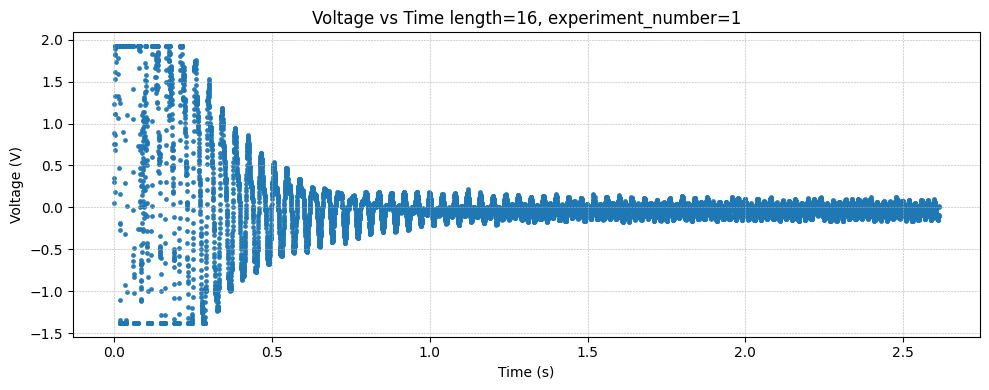

INFO:__main__:Found 217 zero crossings.
INFO:__main__:Calculated 41.61579558538835, youngs_modulus=np.float64(599663172580.1307)
INFO:__main__:Processing iteration i=11
INFO:__main__:Processing: file_object.name='10cm2.csv', length=10, experiment_number=2
INFO:__main__:Loaded 15000 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 6627 samples at start


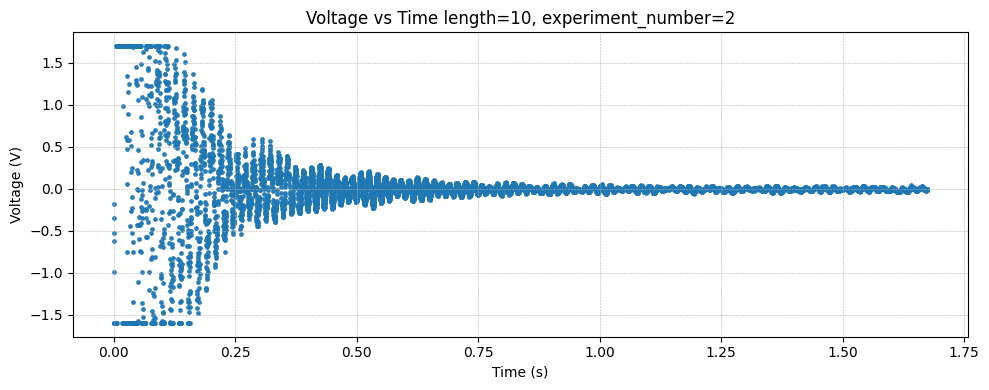

INFO:__main__:Found 239 zero crossings.
INFO:__main__:Calculated 71.58838526214154, youngs_modulus=np.float64(270767277039.15433)
INFO:__main__:Processing iteration i=12
INFO:__main__:Processing: file_object.name='10cm3.csv', length=10, experiment_number=3
INFO:__main__:Loaded 15000 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 6853 samples at start


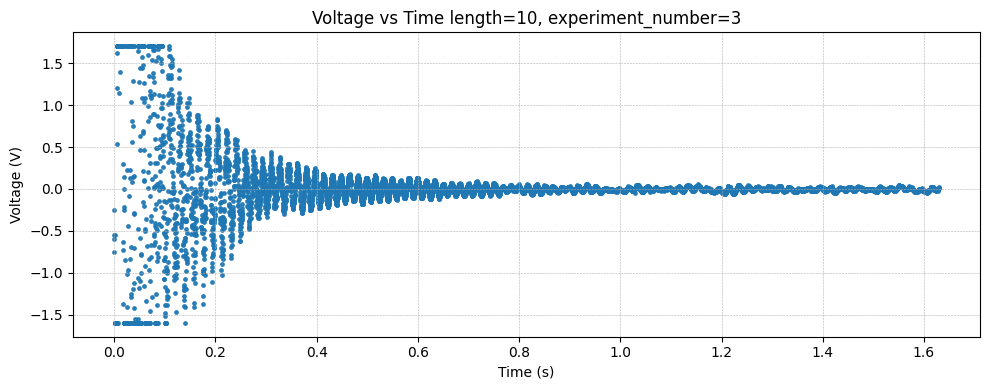

INFO:__main__:Found 239 zero crossings.
INFO:__main__:Calculated 73.33311494918382, youngs_modulus=np.float64(284126217558.40063)
INFO:__main__:Processing iteration i=13
INFO:__main__:Processing: file_object.name='10cm1.csv', length=10, experiment_number=1
INFO:__main__:Loaded 15001 rows of data
INFO:__main__:Noise theshold is 1.1 Volts
INFO:__main__:Discarding 6570 samples at start


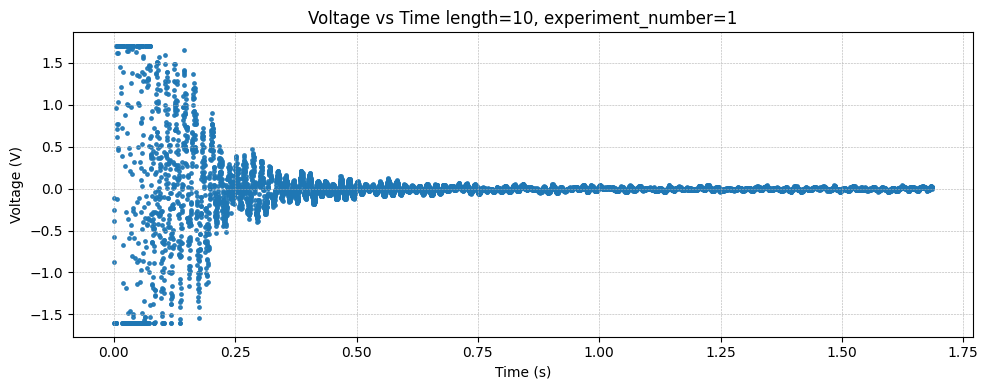

INFO:__main__:Found 289 zero crossings.
INFO:__main__:Calculated 85.96747101887364, youngs_modulus=np.float64(390462513883.74304)


    length  experminent_number  frequency  youngs_modulus
0       15                   1  41.327035    4.568194e+11
1       15                   2  45.435848    5.521707e+11
2       15                   3  41.982582    4.714269e+11
3       13                   3  72.977381    8.036390e+11
4       13                   2  53.648256    4.343058e+11
5       25                   1  35.273331    2.567817e+12
6       13                   1  81.338536    9.983370e+11
7       14                   1  46.292955    4.349637e+11
8       18                   1  31.866201    5.631987e+11
9       20                   1  31.781284    8.538349e+11
10      16                   1  41.615796    5.996632e+11
11      10                   2  71.588385    2.707673e+11
12      10                   3  73.333115    2.841262e+11
13      10                   1  85.967471    3.904625e+11


In [54]:
logging.basicConfig(level=logging.INFO)
script_dir = pathlib.Path.cwd()
set_of_input_files: list[pathlib.Path] = list(script_dir.glob("*.csv"))

log.info(f"Found {len(set_of_input_files)} inputs to process.")
results:list[pandas.DataFrame] = []
for i, input_file_object in enumerate(set_of_input_files):
    log.info(f"Processing iteration {i=}")
    filename_parts = re.search(r"(\d{2,})cm(\d)\.csv", input_file_object.name)
    if filename_parts:
        str_length: int = int(filename_parts[1])
        experiment_number: int = int(filename_parts[2])
        results.append(process_file(
            file_object=input_file_object,
            length=str_length,
            experiment_number=experiment_number,
        ))
    else:
        log.warning(f"Ignoring file {input_file_object.name}")

results_df: pandas.DataFrame = pandas.concat(results, ignore_index=True)

print(results_df)